# Introduction

------------------------------
## Mission - Réalisez une veille technique
------------------------------

Vous avez bien avancé dans la réalisation du dashboard, alors Michaël décide de vous confier une autre mission.

*Bonjour,*

*Merci encore pour tout ce que tu as fait jusqu’à maintenant ! J’ai vu que tu as travaillé sur de nombreux sujets chez nous en plus de celui-ci, en particulier sur des problématiques de données texte (NLP) et de données d’images.*

*Tu sais que nous sommes soucieux de mettre en œuvre les dernières techniques en data science sur ces deux thématiques. Pourrais-tu réaliser un état de l’art sur une technique récente de modélisation de données texte ou de données image, l’analyser, la tester et la comparer à une approche plus classique que tu as réalisée précédemment ?*

*Concrètement, voici ce que j’attends de ta part :*
* *L’état de l’art devra concerner une technique datant de moins de 5 ans, présentée dans un article.*
* *La technique doit être référencée sur des sites de recherche (Arxiv), des sites connus (par exemple fastml, machine learning mastery, kdnuggets, import AI, MIT tech review, MIT news ML) ou des newsletters de qualité comme data elixir et data science weekly.*
* *Tu réaliseras et nous présenteras une preuve de concept qui met en oeuvre cette nouvelle technique avec les données texte ou image que tu as déjà exploitées précédemment.*
* *Tu nous expliqueras rapidement les concepts et techniques dans une note méthodologique (modèle en pièce-jointe) et lors d’une présentation.*

*Je suis convaincu que ta curiosité nous permettra de découvrir de nouvelles techniques performantes.*

*Bonne journée,*

*Michaël*

Bon courage pour cette mission supplémentaire !

# Import des librairies

In [1]:
## Global 
import os
import time
import pandas as pd
import numpy as np

# sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score, auc, \
                                roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# For tensorflow to use CPU instead of GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Keras
import keras
import tensorflow as tf
from keras import layers
from keras.applications import efficientnet
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB3
from plot_keras_history import show_history, plot_history

# Pickle
from pickle import dump, load

# Plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread

import PIL
from PIL import Image

from IPython.display import Image, display

2025-06-21 12:22:31.957966: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-21 12:22:31.965576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750501351.974381 1513568 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750501351.977125 1513568 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-21 12:22:31.986527: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Initialize sns
sns.set()

# Chargement des données et préparations

## Lecture du jeu de données

In [3]:
# Read the dataset from the csv file 
df = pd.read_csv("./data/Flipkart/flipkart_com-ecommerce_sample_1050.csv")
# Define a list of columns to keep
selected_columns = ["product_category_tree", "image"]
# Filter the dataframe with the selected columns
df = df[selected_columns]
# Define path to images
path_to_images = "./data/Flipkart/Images/"
# Concatenate the path to the name of the image
df["image"] = path_to_images + df["image"]
# Simplify category
# Suppress the [" and "] characters
df["product_category_tree"] = df["product_category_tree"].apply(lambda i : i.replace('["', ''))
df["product_category_tree"] = df["product_category_tree"].apply(lambda i : i.replace('"]', ''))
# Get the values of the product_category_tree in a series
product_category_tree = df["product_category_tree"]
# Split the product_category_tree and store it in a list
categories_list = product_category_tree.apply(lambda i : i.split(">>"))
# Go through categories_list and get the biggest list
max_size = 0
for i in range(len(categories_list)):
    # Check if the size is greater than the max_size already found
    if len(categories_list[i]) > max_size:
        # Set the max_size to the new max size
        max_size = len(categories_list[i])
# Generate the columns names based on the max_size
columns = list(range(1,max_size+1))
# Create a dataframe from the list of categories
categories_df = pd.DataFrame(categories_list.to_list(), columns=columns)
# Get the first column of categories_df and set it in a new column in df
df["category"] = categories_df.iloc[:,0]
df = df.drop("product_category_tree", axis=1)
df.head()

,image,category
0,./data/Flipkart/Images/55b85ea15a1536d46b7190a...,Home Furnishing
1,./data/Flipkart/Images/7b72c92c2f6c40268628ec5...,Baby Care
2,./data/Flipkart/Images/64d5d4a258243731dc7bbb1...,Baby Care
3,./data/Flipkart/Images/d4684dcdc759dd9cdf41504...,Home Furnishing
4,./data/Flipkart/Images/6325b6870c54cd47be6ebfb...,Home Furnishing


In [4]:
categories_list = df["category"].unique()

## Encodage de la catégorie

In [5]:
# Define a LabelEncoder
le = LabelEncoder()
# Train the LabelEconder with our categories
le.fit(df["category"])
# Generate the labels
df["label"] = le.transform(df["category"])
df.head()

,image,category,label
0,./data/Flipkart/Images/55b85ea15a1536d46b7190a...,Home Furnishing,4
1,./data/Flipkart/Images/7b72c92c2f6c40268628ec5...,Baby Care,0
2,./data/Flipkart/Images/64d5d4a258243731dc7bbb1...,Baby Care,0
3,./data/Flipkart/Images/d4684dcdc759dd9cdf41504...,Home Furnishing,4
4,./data/Flipkart/Images/6325b6870c54cd47be6ebfb...,Home Furnishing,4


## Séparation du jeu de données

In [6]:
# Split data and labels
data = df["image"]
labels = to_categorical(df["label"])
# Split into work data and validation data
X, X_test, y, y_test = train_test_split(data, labels, test_size=0.15, random_state=8)

In [7]:
# Split into train data and test data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=8)

## Redimensionnement des images

In [8]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 300
BATCH_SIZE = 64

In [9]:
def prepare_images(data):
    # Create a list to store prepared images
    prepared_images = []
    # For each image
    for image in data:
        # Load the image from file
        image = load_img(image, target_size=(IMG_SIZE,IMG_SIZE))
        # Convert it to a numpy array
        image = img_to_array(image)
        # Reshape the image to fit the model needs
        image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
        # Convert the image to an array and store it in the list
        prepared_images.append(image)
        
    return np.array(prepared_images)

In [10]:
# Prepare our datasets train/test/validation
X_train = prepare_images(X_train)
X_val = prepare_images(X_val)
X_test = prepare_images(X_test)

/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


# Définition du modèle

Premièrement, nous initialisons notre modèle avec les poids préentrainés sur ImageNet et nous le fine-tunons pour nos classes.

Toutes les couches sont non entrainables et nous entrainons que la dernière couche.

In [11]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [12]:
model = build_model(num_classes=7)

2025-06-21 12:22:38.615057: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-06-21 12:22:38.615076: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: acer
2025-06-21 12:22:38.615079: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: acer
2025-06-21 12:22:38.615180: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.144.3
2025-06-21 12:22:38.615190: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.144.3
2025-06-21 12:22:38.615191: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.144.3


# Entrainement du modèle

In [13]:
# Create the path where to save the trained model
model_save_path = "./models/model_best_weights.keras"
# Create the path where to save the logs of the training
model_log_path = "./models/model_training_log"
# Create checkpoints to save the model
checkpoint = ModelCheckpoint(model_save_path, monitor="val_loss", verbose=1, 
                             save_best_only=True, mode="min",)
# Create EarlyStopping to stop the training if the model find convergence before the end of the training
early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
# Create the list of callbacks
callbacks_list = [checkpoint, early_stopping]

In [14]:
# Check if the model have already been trained (and saved)
# If true, load the model from the save made
# Used mainly to save time replaying the notebook
if os.path.exists(model_save_path):
    # Open the model from the file
    model = load_model(model_save_path)
    # Open the log file of training
    history = np.load(model_log_path + ".npy", allow_pickle="True").item()
else:
    # Initialize the time at the beginning of the function
    beginning_time = time.time()
    
    # Training of the model on the train set
    history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                         callbacks=callbacks_list, validation_data=(X_val, y_val),
                         verbose=1)
    # Save the history of training to a file
    np.save(model_log_path, history.history)
    # Calculate the duration time of the function
    time_training = np.round(time.time() - beginning_time,0)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5617 - loss: 1.4986
Epoch 1: val_loss improved from inf to 0.54137, saving model to ./models/model_best_weights.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5755 - loss: 1.4602 - val_accuracy: 0.8386 - val_loss: 0.5414
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9450 - loss: 0.2110
Epoch 2: val_loss did not improve from 0.54137
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9432 - loss: 0.2209 - val_accuracy: 0.8341 - val_loss: 0.5944
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9556 - loss: 0.1895
Epoch 3: val_loss did not improve from 0.54137
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9553 - loss: 0.1919 - val_accuracy: 0.8072 - val_loss: 0.5897
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9590 - loss: 0.1596
Epoch 4: val_loss did not improve from 0.54137
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9588 - loss: 0.1570 - val_accur

La deuxième étape est de rendre entrainable certaines couches du modèles et d'entrainer le modèle avec un learning rate plus faible.

In [15]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)

In [16]:
# Create the path where to save the trained model
model_unfreezed_save_path = "./models/model_unfreezed_best_weights.keras"
# Create the path where to save the logs of the training
model_unfreezed_log_path = "./models/model_unfreezed_training_log"
# Create checkpoints to save the model
checkpoint_unfreezed = ModelCheckpoint(model_unfreezed_save_path, monitor="val_loss", verbose=1, 
                             save_best_only=True, mode="min",)
# Create EarlyStopping to stop the training if the model find convergence before the end of the training
early_stopping_unfreezed = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
# Create the list of callbacks
callbacks_list_unfreezed = [checkpoint_unfreezed, early_stopping_unfreezed]

In [17]:
# Check if the model have already been trained (and saved)
# If true, load the model from the save made
# Used mainly to save time replaying the notebook
if os.path.exists(model_unfreezed_save_path):
    # Open the model from the file
    model = load_model(model_unfreezed_save_path)
    # Open the log file of training
    history = np.load(model_unfreezed_log_path + ".npy", allow_pickle="True").item()
else:
    # Initialize the time at the beginning of the function
    beginning_time = time.time()
    
    # Training of the model on the train set
    history = model.fit(X_train, y_train, epochs=10, batch_size=64,
                         callbacks=callbacks_list_unfreezed, validation_data=(X_val, y_val),
                         verbose=1)
    # Save the history of training to a file
    np.save(model_unfreezed_log_path, history.history)
    # Calculate the duration time of the function
    time_training2 = np.round(time.time() - beginning_time,0)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9832 - loss: 0.0462
Epoch 1: val_loss improved from inf to 0.62708, saving model to ./models/model_unfreezed_best_weights.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9833 - loss: 0.0458 - val_accuracy: 0.8386 - val_loss: 0.6271
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9855 - loss: 0.0573
Epoch 2: val_loss did not improve from 0.62708
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9853 - loss: 0.0575 - val_accuracy: 0.8341 - val_loss: 0.6320
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9819 - loss: 0.0465
Epoch 3: val_loss did not improve from 0.62708
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9819 - loss: 0.0469 - val_accuracy: 0.8386 - val_loss: 0.6382
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9947 - loss: 0.0206
Epoch 4: val_loss did not improve from 0.62708
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9946 - loss: 0.0210 -

# Scoring et analyse

In [18]:
# Get the scores of the last epoch
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 859ms/step - accuracy: 0.9988 - loss: 0.0236
Training Accuracy: 0.9985

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 857ms/step - accuracy: 0.8364 - loss: 0.7812
Validation Accuracy:  0.8475


In [19]:
# Get the scores of the optimal epoch
model.load_weights(model_save_path)

loss_validation, accuracy_validation = model.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy       :  {:.4f}".format(accuracy_validation))
print("Validation Loss           :  {:.4f}".format(loss_validation))

loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy             :  {:.4f}".format(accuracy_test))
print("Test Loss                 :  {:.4f}".format(loss_test))

/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Validation Accuracy       :  0.8386
Validation Loss           :  0.5414
Test Accuracy             :  0.8608
Test Loss                 :  0.4805


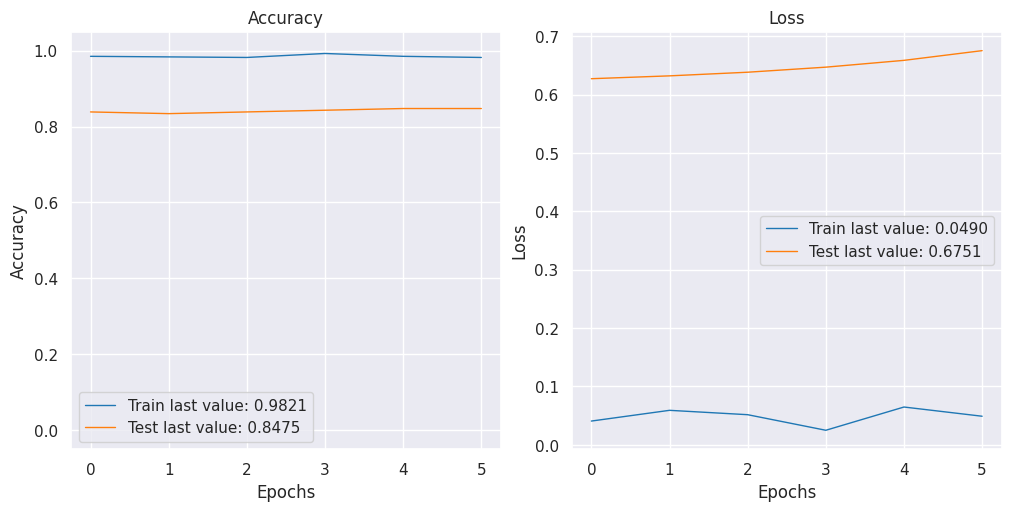

In [20]:
# Plot the history of training
show_history(history)
plot_history(history, path="./models/model_history.png")
plt.close()

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step  


<Axes: >

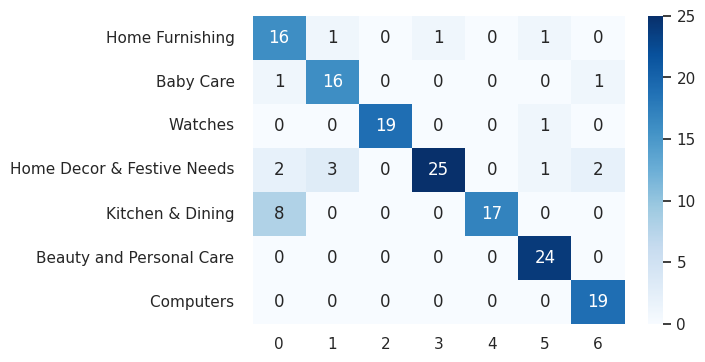

In [21]:
# Get the values of the clusters
y_test_true = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)
# Calculate the confusion matrix 
conf_mat = confusion_matrix(y_test_true, y_test_pred)
# Convert the confusion matrix to a DataFrame
df_conf_mat = pd.DataFrame(conf_mat, index = [label for label in categories_list],
                  columns = [i for i in "0123456"])
# Plot it
plt.figure(figsize = (6,4))
sns.heatmap(df_conf_mat, annot=True, cmap="Blues")

# Comparaison des scores avec les scores du Projet 6

In [22]:
scores = pd.read_csv("./scores.csv")

In [23]:
scores

,Index,loss_validations,loss_tests,accuracy_validations,accuracy_tests,training_times
0,Méthode 1,0.916748,0.884279,0.789238,0.797468,73.0
1,Méthode 2,0.420820,0.788629,0.896861,0.841772,99.0
2,Méthode 3,0.332204,0.743338,0.896861,0.829114,38.0
3,Méthode 4,0.393028,0.572600,0.860987,0.841772,128.0


In [24]:
method5 = pd.DataFrame(
    ["Méthode 5", loss_validation, loss_test, accuracy_validation, accuracy_test, time_training+time_training2],
    index=[
        "Index",
        "loss_validations",
        "loss_tests",
        "accuracy_validations",
        "accuracy_tests",
        "training_times"
    ]
)

In [25]:
scores = pd.concat([scores, method5.T], ignore_index=True)
scores

,Index,loss_validations,loss_tests,accuracy_validations,accuracy_tests,training_times
0,Méthode 1,0.916748,0.884279,0.789238,0.797468,73.0
1,Méthode 2,0.42082,0.788629,0.896861,0.841772,99.0
2,Méthode 3,0.332204,0.743338,0.896861,0.829114,38.0
3,Méthode 4,0.393028,0.5726,0.860987,0.841772,128.0
4,Méthode 5,0.541367,0.480469,0.838565,0.860759,312.0


Text(0.5, 0, 'Méthode')

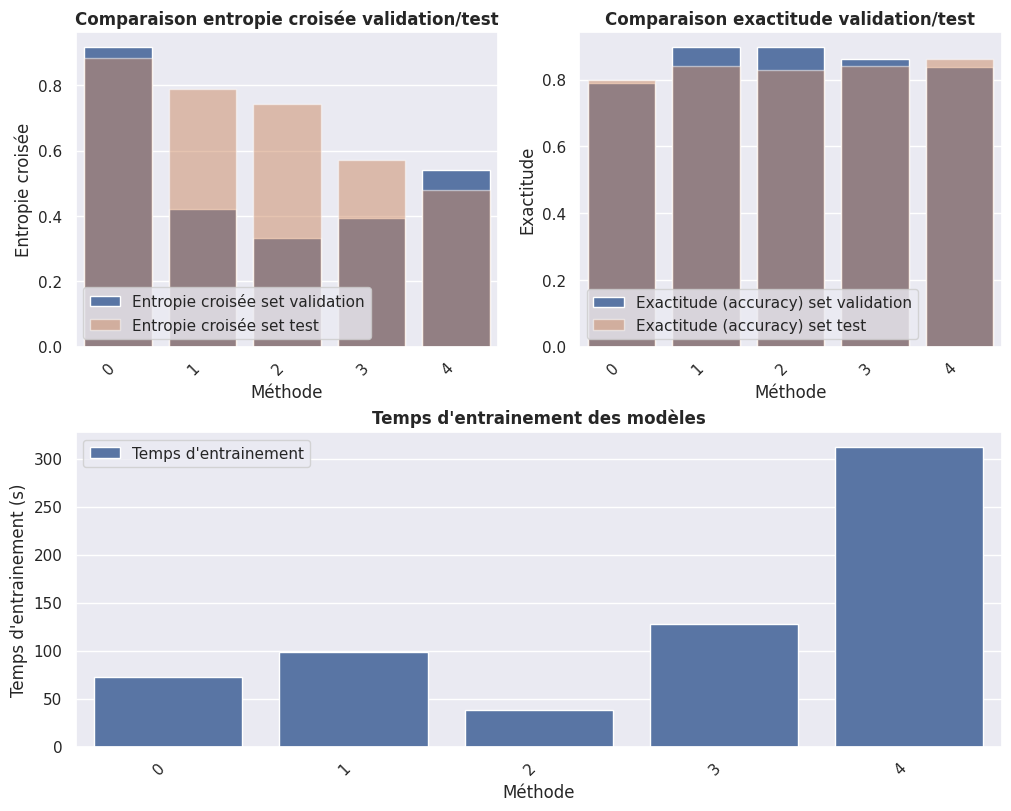

In [26]:
fig = plt.figure(figsize=(10,8), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=2)

fig_ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(data=scores, x=scores.index, y = "loss_validations", 
            label="Entropie croisée set validation")
sns.barplot(data=scores, x=scores.index, y = "loss_tests", 
            label="Entropie croisée set test", alpha=0.5)
plt.title("Comparaison entropie croisée validation/test", fontweight="bold")
plt.legend(loc="lower left")
plt.ylabel("Entropie croisée")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Méthode")

fig_ax1 = fig.add_subplot(gs[0, 1])
sns.barplot(data=scores, x=scores.index, y = "accuracy_validations", 
            label="Exactitude (accuracy) set validation")
sns.barplot(data=scores, x=scores.index, y = "accuracy_tests", 
            label="Exactitude (accuracy) set test", alpha=0.5)
plt.title("Comparaison exactitude validation/test", fontweight="bold")
plt.legend(loc="lower left")
plt.ylabel("Exactitude")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Méthode")

fig_ax1 = fig.add_subplot(gs[1, :])
sns.barplot(data=scores, x=scores.index, y = "training_times", 
            label="Temps d'entrainement")
plt.title("Temps d'entrainement des modèles", fontweight="bold")
plt.ylabel("Temps d'entrainement (s)")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Méthode")

On constate que les scores sont légèrement améliorés par rapport aux modèles testés précédemment.

Le temps d'entrainement est cependant très défavorable à ce modèle. Notons cependant que les conditions d'entrainement ne sont pas similaires car il n'a pas été possible ici d'utiliser la GPU comme précédemment pour des problèmes de RAM disponible.

<img src="./M1.png" width="400" height="400"> <img src="./M2.png" width="400" height="400">
<img src="./M3.png" width="400" height="400"> <img src="./M4.png" width="400" height="400">
<img src="./M5.png" width="400" height="400">

Cela se vérifie lorsqu'on affiche les matrices de confusion. Nous pouvons constater moins d'images mal classées.

# Feature importance

Les modèles à base de CNN sont difficilement interprétables. Afin d'étudier la feature importance et donc l'interprétabilité du modèle, plusieurs techniques ont été proposées par les chercheurs.

Le papier de recherche de notre modèle suggère une utilisation de la Class Activation Map pour étudier la manière dont les images sont interprétées. 

C'est ce que nous utiliserons ici.

In [27]:
# Open the model from the file
model = load_model(model_unfreezed_save_path)
# Open the log file of training
model.summary()

Model: "EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 14,708,230 (56.11 MB)

 Trainable params: 1,953,895 (7.45 MB)

 Non-trainable params: 8,846,543 (33.75 MB)

 Optimizer params: 3,907,792 (14.91 MB)

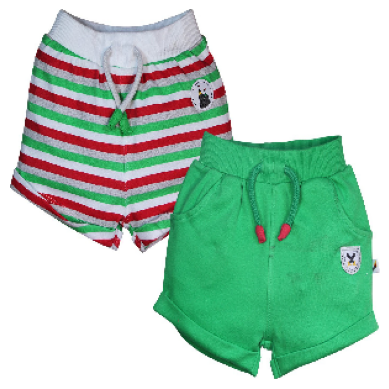

In [28]:
# Open the image
img = X_test[137]
img = img.astype(int)
# Plot the image
plt.imshow(img)
# Suppress the axis for better visibility
plt.axis("off") 
plt.show()

In [29]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv", pred_index=None):
    img_array = img_array.reshape(
        (1, img_array.shape[0], img_array.shape[1], img_array.shape[2])
    )
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [30]:
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(np.expand_dims(img, axis=0))
print("Predicted:", categories_list[np.argmax(preds)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted: Home Furnishing 


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 300, 300, 3))
  warnings.warn(msg)


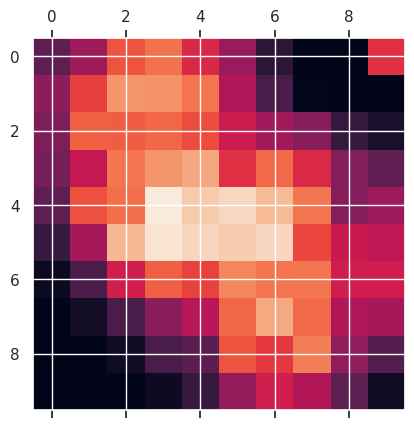

In [31]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img, model)
# Display heatmap
plt.matshow(heatmap)
plt.show()

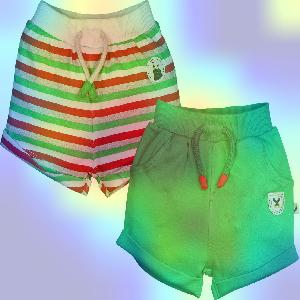

In [32]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img, heatmap)